# Project Final Report

### Due: Midnight on April 27 (2-hour grace period) — 50 points  

### No late submissions will be accepted.


## Overview

Your final submission consists of **three components**:

---

### 1. Final Report Notebook [40 pts]

Complete all sections of this notebook to document your final decisions, results, and broader context.

- **Part A**: Select the single best model from your Milestone 2 experiments. Now that you’ve finalized your model, revisit your decisions from Milestones 1 and 2. Are there any steps you would change—such as cleaning, feature engineering, or model evaluation—given what you now know?

- **Part B**: Write a technical report following standard conventions, for example:
  - [CMU guide to structure](https://www.stat.cmu.edu/~brian/701/notes/paper-structure.pdf)
  - [Data science report example](https://www.projectpro.io/article/data-science-project-report/620)
  - The Checklist given in this week's Blackboard Lesson (essentially the same as in HOML).
    
  Your audience here is technically literate but unfamiliar with your work—like your manager or other data scientists. Be clear, precise, and include both code (for illustration), charts/plots/illustrations, and explanation of what you discovered and your reasoning process. 

The idea here is that Part A would be a repository of the most important code, for further work to come, and Part B is
the technical report which summarizes your project for the data science group at your company. Do NOT assume that readers of Part B are intimately familiar with Part A; provide code for illustration as needed, but not to run.

Submit this notebook as a group via your team leader’s Gradescope account.

---

### 2. PowerPoint Presentation [10 pts]

Create a 10–15 minute presentation designed for a general audience (e.g., sales or marketing team).

- Prepare 8–12 slides, following the general outline of the sections of Part B. 
- Focus on storytelling, visuals (plots and illustrations), and clear, simplified language. No code!
- Use any presentation tool you like, but upload a PDF version.
- List all team members on the first slide.

Submit as a group via your team leader’s Gradescope account.

---

### 3. Individual Assessment

Each team member must complete the Individual Assessment Form (same as in Milestone 1), sign it, and upload it via their own Gradescope account.

---

## Submission Checklist

-  Final Report Notebook — Team leader submission
-  PDF Slides — Team leader submission
-  Individual Assessment Form — Each member submits their own


## Part A: Final Model and Design Reassessment [10 pts]

In this part, you will finalize your best-performing model and revisit earlier decisions to determine if any should be revised in light of your complete modeling workflow. You’ll also consolidate and present the key code used to run your model on the preprocessed dataset, with thoughtful documentation of your reasoning.

**Requirements:**

- Reconsider **at least one decision from Milestone 1** (e.g., preprocessing, feature engineering, or encoding). Explain whether you would keep or revise that decision now that you know which model performs best. Justify your reasoning.
  
- Reconsider **at least one decision from Milestone 2** (e.g., model evaluation, cross-validation strategy, or feature selection). Again, explain whether you would keep or revise your original decision, and why.

- Below, include all code necessary to **run your final model** on the processed dataset. This section should be a clean, readable summary of the most important steps from Milestones 1 and 2, adapted as needed to fit your final model choice and your reconsiderations as just described. 

- Use Markdown cells and inline comments to explain the structure of the code clearly but concisely. The goal is to make your reasoning and process easy to follow for instructors and reviewers.

> Remember: You are not required to change your earlier choices, but you *are* required to reflect on them and justify your final decisions.


## Import Necessary Libraries

In [50]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

## Clean the Data

In [2]:
url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df_zillow = pd.read_csv(filename)

File already exists. Skipping download.


In [3]:
# Check count and percentage of missing data for each columns
def show_null_counts_features(df):
    # Count the nulls and calculate the %
    count_nulls = df.isnull().sum()
    df_nulls = (df.isnull().mean() * 100).round(2)

    # Determine if the column is numeric or non-numeric
    feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')

    # Filter out the columns with missing values and sort them in descending order
    missing_data = pd.DataFrame({
        'Feature': count_nulls[count_nulls > 0].index,
        '# Null Values': count_nulls[count_nulls > 0].values,
        'Null %': df_nulls[df_nulls > 0].values,
        'Type': feature_types[count_nulls > 0].values
    }).sort_values(by='Null %', ascending=False)

    print(f'The dataset contains {len(df)} samples.\n')

    if (len(missing_data) == 0):
        print("There are no null values in the dataset!")
    else:
        # Print null value stats
        print('Feature Name                  # Nulls      Null %     Type')
        print('------------                  -------      ------     ----')
        for index, row in missing_data.iterrows():
            print(f"{row['Feature']:<30} {row['# Null Values']:<11} {row['Null %']:.2f}%   {row['Type']}")

In [4]:
# Drop features that are unsuitable for the project
unsuitable_list = ['parcelid', 'fips', 'rawcensustractandblock', 'censustractandblock',
                   'latitude', 'longitude', 'propertyzoningdesc', 'propertycountylandusecode',
                   'assessmentyear'
                   ]
df_unsuitable_dropped = df_zillow.drop(columns = unsuitable_list)

df_unsuitable_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 46 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         25007 non-null  float64
 1   architecturalstyletypeid      207 non-null    float64
 2   basementsqft                  50 non-null     float64
 3   bathroomcnt                   77579 non-null  float64
 4   bedroomcnt                    77579 non-null  float64
 5   buildingclasstypeid           15 non-null     float64
 6   buildingqualitytypeid         49809 non-null  float64
 7   calculatedbathnbr             76963 non-null  float64
 8   decktypeid                    614 non-null    float64
 9   finishedfloor1squarefeet      6037 non-null   float64
 10  calculatedfinishedsquarefeet  77378 non-null  float64
 11  finishedsquarefeet12          73923 non-null  float64
 12  finishedsquarefeet13          42 non-null     float64
 13  f

In [5]:
exceptions = ['taxdelinquencyflag', 'poolcnt', 'fireplacecnt', 'unitcnt', 'garagecarcnt', 'hashottuborspa', 'basementsqft']

max_nulls = 50000  # Drop columns with more than 50,000 missing
df_null_dropped = df_unsuitable_dropped.loc[:,
                  (df_unsuitable_dropped.isnull().sum() < max_nulls) |
                  (df_unsuitable_dropped.columns.isin(exceptions))
                  ]

show_null_counts_features(df_null_dropped)

The dataset contains 77613 samples.

Feature Name                  # Nulls      Null %     Type
------------                  -------      ------     ----
basementsqft                   77563       99.94%   Numeric
hashottuborspa                 76074       98.02%   Categorical
taxdelinquencyflag             74713       96.26%   Categorical
fireplacecnt                   69324       89.32%   Numeric
poolcnt                        61439       79.16%   Numeric
garagecarcnt                   52093       67.12%   Numeric
regionidneighborhood           46639       60.09%   Numeric
heatingorsystemtypeid          28042       36.13%   Numeric
buildingqualitytypeid          27804       35.82%   Numeric
unitcnt                        26910       34.67%   Numeric
lotsizesquarefeet              8292        10.68%   Numeric
finishedsquarefeet12           3690        4.75%   Numeric
regionidcity                   1506        1.94%   Numeric
fullbathcnt                    650         0.84%   Numeric


35 samples were dropped due to missing target.


Text(0.5, 0, 'taxvaluedollarcnt')

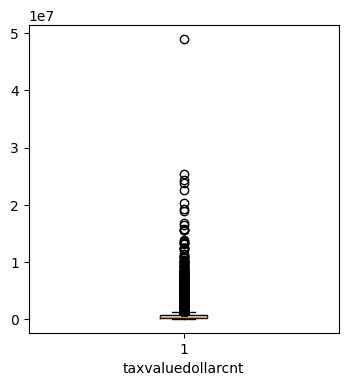

In [6]:
# Drop samples where the target is missing
df_clean_missing_target = df_null_dropped[~df_null_dropped['taxvaluedollarcnt'].isna()]
print(f'{df_null_dropped.shape[0] - df_clean_missing_target.shape[0]} samples were dropped due to missing target.')

# Boxplot to check outlier
plt.figure(figsize=(4, 4))
plt.boxplot(df_clean_missing_target['taxvaluedollarcnt'])
plt.xlabel('taxvaluedollarcnt')

1020 samples were dropped due to outliers in target.


Text(0.5, 0, 'taxvaluedollarcnt')

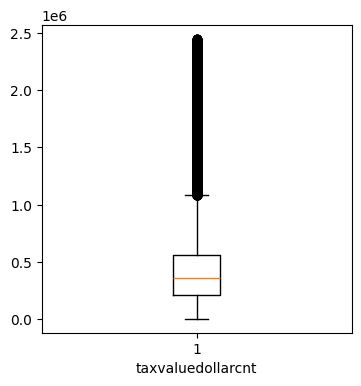

In [7]:
# Drop samples with extreme outliers in the target (i.e., > 3SD from the mean)
from scipy.stats import zscore

z_scores = np.abs(zscore(df_clean_missing_target['taxvaluedollarcnt'])) # Calculate z-scores
df_clean_target = df_clean_missing_target[z_scores < 3]

print(f'{df_clean_missing_target.shape[0] - df_clean_target.shape[0]} samples were dropped due to outliers in target.')

# Boxplot to check outlier
plt.figure(figsize=(4, 4))
plt.boxplot(df_clean_target['taxvaluedollarcnt'])
plt.xlabel('taxvaluedollarcnt')

In [8]:
# Drop samples with too many missing values (i.e., more than 50% nulls)
num_missing = int(df_clean_target.shape[1] * 0.5)
df_clean_missing = df_clean_target[df_clean_target.isnull().sum(axis=1) < num_missing]
print(f'{df_clean_target.shape[0] - df_clean_missing.shape[0]} samples were dropped due to too many missing values.')

276 samples were dropped due to too many missing values.


In [9]:
df_imputed = df_clean_missing.copy()

In [10]:
# Drop samples with missing value in features with < 5% NA
drop_NA_list = ['finishedsquarefeet12', 'regionidcity', 'calculatedbathnbr', 'fullbathcnt', 'yearbuilt', 'regionidzip', 'calculatedfinishedsquarefeet']
for feature in drop_NA_list:
  df_imputed = df_imputed.dropna(subset=[feature])
show_null_counts_features(df_imputed)

The dataset contains 71385 samples.

Feature Name                  # Nulls      Null %     Type
------------                  -------      ------     ----
basementsqft                   71335       99.93%   Numeric
hashottuborspa                 70021       98.09%   Categorical
taxdelinquencyflag             68826       96.42%   Categorical
fireplacecnt                   63271       88.63%   Numeric
poolcnt                        56206       78.74%   Numeric
garagecarcnt                   46781       65.53%   Numeric
regionidneighborhood           42915       60.12%   Numeric
buildingqualitytypeid          26009       36.43%   Numeric
unitcnt                        25734       36.05%   Numeric
heatingorsystemtypeid          24499       34.32%   Numeric
lotsizesquarefeet              7961        11.15%   Numeric


In [11]:
# To make life easier, we imputed garagecarcnt with "0", however as there is already 230 '0' counts, we create a new variable 'garageunknown'
df_imputed.insert(
    df_imputed.columns.get_loc('garagecarcnt') + 1,
    'garageunknown',
    np.where(df_imputed['garagecarcnt'].isna(), 1, 0)
)

In [12]:
# Impute features that missing indicate 0
missing_to_zero_list = ['taxdelinquencyflag', 'poolcnt', 'fireplacecnt', 'unitcnt', 'hashottuborspa', 'basementsqft', 'garagecarcnt']
for feature in missing_to_zero_list:
  df_imputed[feature] = df_imputed[feature].fillna(0)

show_null_counts_features(df_imputed)

The dataset contains 71385 samples.

Feature Name                  # Nulls      Null %     Type
------------                  -------      ------     ----
regionidneighborhood           42915       60.12%   Numeric
buildingqualitytypeid          26009       36.43%   Numeric
heatingorsystemtypeid          24499       34.32%   Numeric
lotsizesquarefeet              7961        11.15%   Numeric


In [13]:
# Impute numeric (continuous) features
# Impute lotsizesquarefeet with midian as it is skewed
missing_to_median_list = ['lotsizesquarefeet']
for feature in missing_to_median_list:
  df_imputed[feature] = df_imputed[feature].fillna(df_imputed[feature].median())

show_null_counts_features(df_imputed)

The dataset contains 71385 samples.

Feature Name                  # Nulls      Null %     Type
------------                  -------      ------     ----
regionidneighborhood           42915       60.12%   Numeric
buildingqualitytypeid          26009       36.43%   Numeric
heatingorsystemtypeid          24499       34.32%   Numeric


In [14]:
# Impute categorical features with mode
missing_to_mode_list = ['regionidneighborhood', 'buildingqualitytypeid', 'heatingorsystemtypeid']
for feature in missing_to_mode_list:
  df_imputed[feature] = df_imputed[feature].fillna(df_imputed[feature].mode().iloc[0])

show_null_counts_features(df_imputed)

The dataset contains 71385 samples.

There are no null values in the dataset!


In [15]:
df_main = df_imputed.copy()
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71385 entries, 0 to 77612
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   basementsqft                  71385 non-null  float64
 1   bathroomcnt                   71385 non-null  float64
 2   bedroomcnt                    71385 non-null  float64
 3   buildingqualitytypeid         71385 non-null  float64
 4   calculatedbathnbr             71385 non-null  float64
 5   calculatedfinishedsquarefeet  71385 non-null  float64
 6   finishedsquarefeet12          71385 non-null  float64
 7   fireplacecnt                  71385 non-null  float64
 8   fullbathcnt                   71385 non-null  float64
 9   garagecarcnt                  71385 non-null  float64
 10  garageunknown                 71385 non-null  int64  
 11  hashottuborspa                71385 non-null  object 
 12  heatingorsystemtypeid         71385 non-null  float64
 13  lotsiz

In [16]:
# As hashottuborspa and taxdelinquencyflag are binary, directly converted to bool
object_type_list = ['hashottuborspa', 'taxdelinquencyflag']

for feature in object_type_list:
  df_main[feature] = df_main[feature].astype(bool)

In [17]:
# Export the cleaned dataset to a csv file
df_main.to_csv('zillow_cleaned.csv', index=False)

## Load Data Function

In [18]:
def load_data(path, target_column=None, random_state=random_state):
    # Load the dataset
    df = pd.read_csv(path)

    # check if the dataset has been loaded properly
    if df.empty:
        raise ValueError("the dataset is empty, please check the path or the file content.")
    print(f"loaded dataset with shape: {df.shape}")

    # Split the data into features and target variables
    X = df.drop(columns=target_column)
    y = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )

    # create scaled versions of the train and test features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)

    # Convert scaled data back to DataFrame for better readability
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    return X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, df

In [19]:
# Load the data from github and preprocess the data
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, df = load_data('zillow_cleaned.csv',target_column='taxvaluedollarcnt')

loaded dataset with shape: (71385, 25)


## Run and Evaluate Model Functions

In [20]:
def run_model(model, x_train, y_train, return_model=False, n_repeats=5, n_jobs=-1, random_state=random_state, **model_params):

    # Instantiate the model if a class is provided, so for example can use either BaggingRegressor or BaggingRegressor() as argument. 
    if isinstance(model, type):
        model = model(**model_params)

    neg_rmse_scores = cross_val_score(model, x_train, y_train, scoring = 'neg_root_mean_squared_error',
                                     cv = RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=random_state), n_jobs = n_jobs)
    
    mean_cv_rmse = -np.mean(neg_rmse_scores)
    std_cv_rmse  = np.std(neg_rmse_scores)
    
    # Fit the model on the full training set
    model.fit(x_train, y_train)
    
    # Compute training RMSE
    if return_model:
        train_preds = model.predict(x_train)
        train_rmse = root_mean_squared_error(y_train, train_preds)
        
        return mean_cv_rmse, std_cv_rmse, train_rmse, model
    
    else:
        train_preds = model.predict(x_train)
        train_rmse = root_mean_squared_error(y_train, train_preds)

        return mean_cv_rmse, std_cv_rmse, train_rmse

In [21]:
def evaluate_model(
    models, 
    x_train, y_train,
    return_model=False,
    random_state=random_state, 
    **model_params
):

    results = {}
    fitted_models = {}

    for name, model in models.items():
        print(f"Evaluating {name}…")

        if return_model:
            # run_model must accept x_test, y_test, test=True
            mean_cv_rmse, std_cv_rmse, train_rmse, fitted_model = run_model(
                model,
                x_train, y_train,
                return_model=True,
                random_state=random_state,
                **model_params
            )
            fitted_models[name] = fitted_model
        else:
            # only get the three training‐set metrics
            mean_cv_rmse, std_cv_rmse, train_rmse = run_model(
                model,
                x_train, y_train,
                return_model=False,
                random_state=random_state,
                **model_params
            )
        # now format only the things you actually have
        row = {
            'Mean CV RMSE': dollar_format(mean_cv_rmse, 2),
            'STD CV RMSE' : dollar_format(std_cv_rmse, 2),
            'Train RMSE': dollar_format(train_rmse, 2),
        }

        results[name] = row

    df = pd.DataFrame(results).T
    df.index.name = 'Model'

    if return_model:
        return df.sort_values(by='Mean CV RMSE'), fitted_models
    else:
        return df.sort_values(by='Mean CV RMSE')


## Data Transformation

In [22]:
# square footage features have large values and are highly skewed, consider log transformation

# basementsqft, fireplacecnt, garagecarcnt, poolcnt have a lot of zeros (> 75%)), consider transforming them to binary features
zero_list = [
    'basementsqft',
    'fireplacecnt',
    'garagecarcnt',
]
# Check the percentage of zeros in the zero_list features
for col in zero_list:
    zero_percentage = (df[col] == 0).mean() * 100
    print(f"{col}: {zero_percentage:.2f}% zeros")

basementsqft: 99.93% zeros
fireplacecnt: 88.63% zeros
garagecarcnt: 65.58% zeros


(57108, 27)

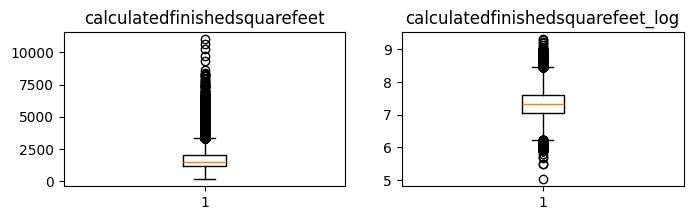

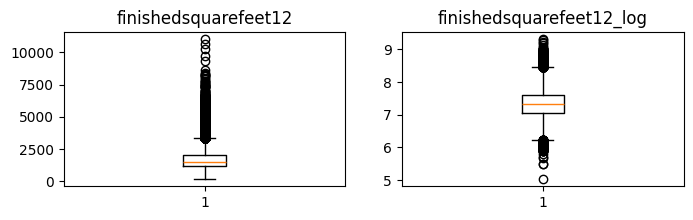

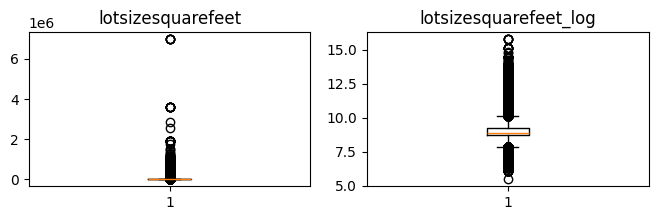

In [23]:
# log transfermation of square footage features

# define log transformation function
def log_transformation(df, column):
  df[f'{column}_log_transformed'] = np.log(df[column])
  fig, axes = plt.subplots(1, 2, figsize=(8,2))
  axes[0].boxplot(df[column])
  axes[0].set_title(column)
  axes[1].boxplot(df[f'{column}_log_transformed'])
  axes[1].set_title(f'{column}_log')

# apply log transformation to selected columns with large values and high skewness
# (all square footage columns except for basementsqft as it has only 38 non-zero rows)
X_train_log = X_train.copy()
log_list = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'lotsizesquarefeet']

for f in log_list:
    log_transformation(X_train_log, f)

X_train_log.shape

In [24]:
# polynomial transformation

# define polynomial transformation function
def polynomial_transformation(df, column, degree):
  df[f'{column}_poly_transformed'] = df[column]**degree
  fig, axes = plt.subplots(1, 2, figsize=(8,2))
  axes[0].boxplot(df[column])
  axes[0].set_title(column)
  axes[1].boxplot(df[f'{column}_poly_transformed'])
  axes[1].set_title(f'{column}_poly')

# # apply polynomial transformation to selected columns
# X_train_poly = X_train_log.copy()
# poly_list = ['calculatedbathnbr']
# for f in poly_list:
#   polynomial_transformation(X_train_poly, f, 2)

In [25]:
# encoder for Categorical features

# define one-hot encoding function
def one_hot_encode(df, columns):
    df = df.copy()
    df[columns] = df[columns].astype(str)

    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded = encoder.fit_transform(df[columns])
    encoded_df = pd.DataFrame(
        encoded,
        columns=encoder.get_feature_names_out(columns),
        index=df.index
    )

    df = pd.concat([df, encoded_df], axis=1)
    return df

# apply one-hot encoding to selected categorical features (id type features without too many unique values)
encode_list = ['regionidcounty', 'heatingorsystemtypeid', 'propertylandusetypeid' ]
X_train_encoded = one_hot_encode(X_train_log, encode_list)
X_train_encoded.shape

(57108, 50)

In [26]:
# convert zero_list features to binary features
def convert_to_binary(df, column):
        df[f'{column}_binary'] = (df[column] != 0).astype(int)

X_train_binary = X_train_encoded.copy()
print(zero_list)
for f in zero_list:
    convert_to_binary(X_train_binary, f)

X_train_binary.shape
print(X_train_binary.info())

['basementsqft', 'fireplacecnt', 'garagecarcnt']
<class 'pandas.core.frame.DataFrame'>
Index: 57108 entries, 33730 to 15795
Data columns (total 53 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   basementsqft                                  57108 non-null  float64
 1   bathroomcnt                                   57108 non-null  float64
 2   bedroomcnt                                    57108 non-null  float64
 3   buildingqualitytypeid                         57108 non-null  float64
 4   calculatedbathnbr                             57108 non-null  float64
 5   calculatedfinishedsquarefeet                  57108 non-null  float64
 6   finishedsquarefeet12                          57108 non-null  float64
 7   fireplacecnt                                  57108 non-null  float64
 8   fullbathcnt                                   57108 non-null  float64
 9   garagecarcnt 

In [27]:
# Standardize the transformed features
scaler = StandardScaler()
X_train_transformed_scaled = scaler.fit_transform(X_train_binary)

X_train_transformed_scaled = pd.DataFrame(X_train_transformed_scaled, columns = X_train_binary.columns)

print(X_train_transformed_scaled.shape)
print(y_train.shape)

(57108, 53)
(57108,)


In [28]:
# create a list of all transformed features
transformed_features = log_list + encode_list + zero_list
print(len(transformed_features), transformed_features)

# create a df without the orginal features
X_train_transformed_scaled_original_dropped = X_train_transformed_scaled.drop(columns=transformed_features)
X_train_transformed_scaled_original_dropped.shape

9 ['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'lotsizesquarefeet', 'regionidcounty', 'heatingorsystemtypeid', 'propertylandusetypeid', 'basementsqft', 'fireplacecnt', 'garagecarcnt']


(57108, 44)

- Reconsider **at least one decision from Milestone 1** (e.g., preprocessing, feature engineering, or encoding). Explain whether you would keep or revise that decision now that you know which model performs best. Justify your reasoning.

One reconsideration from Milestone 1 would be to remove Polynomial transformations from the feature engineering section. In testing, adding a polynomial greater than 1 on any of the features degraded the training rmse values for the gradient boosting model. The transformations most beneficial to the Gradient Boosting model were ones that minimized any type of variance.

## Baseline Models

In [51]:
# models with default parameters
model_dict = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Bagging": BaggingRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
    }

In [52]:
baseline_results, baseline_model = evaluate_model(model_dict, X_train_transformed_scaled_original_dropped, y_train, return_model=True, random_state=random_state)
print(baseline_results)

Evaluating Linear…
Evaluating Ridge…
Evaluating Lasso…


c:\Users\JT von Seggern\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.208e+15, tolerance: 7.282e+11
  model = cd_fast.enet_coordinate_descent(


Evaluating Decision Tree…
Evaluating Bagging…
Evaluating Random Forest…
Evaluating Gradient Boosting…
                  Mean CV RMSE STD CV RMSE Train RMSE
Model                                                
Random Forest         $241,751      $2,342    $92,251
Gradient Boosting     $245,853      $2,259   $242,019
Bagging               $252,169      $2,215   $107,380
Lasso                 $282,834      $2,837   $282,565
Linear                $282,835      $2,837   $282,565
Ridge                 $282,835      $2,837   $282,565
Decision Tree         $332,569      $3,704    $24,149


## Parameter Sweeping

In [29]:
def sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    x_train          = X_train_scaled,
                    y_train          = y_train,
                    verbose          = True,
                    show_rmse        = True,
                    n_iter_no_change = None,
                    delta            = 0.001):
    
    start = time.time()
    Parameters = Parameters.copy()  # Avoid modifying the original dictionary
    
    cv_rmses, std_cvs, train_rmses = [], [], []
    no_improve_count = 0
    best_rmse = float('inf')
    
    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        # Remove MSE_found if present, just in case
        P_temp.pop('RMSE_found', None)
        
        cv_rmse, std_cv, train_rmse = run_model(
            model, x_train, y_train, **P_temp
        )
        
        cv_rmses.append(cv_rmse)
        std_cvs.append(std_cv)
        train_rmses.append(train_rmse)
        
        # Early-stopping logic
        if cv_rmse < best_rmse - delta:
            best_rmse = cv_rmse
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break
    
    # Identify best parameter
    min_cv_rmse = min(cv_rmses)
    min_index = cv_rmses.index(min_cv_rmse)
    best_param = parameter_list[min_index]
    Parameters[param] = best_param
    Parameters['RMSE_found'] = min_cv_rmse
    
    if verbose:
        # Prepare for plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
        
        # We only need as many parameter values as we actually computed
        partial_param_list = parameter_list[:len(cv_rmses)]
        
        # Check if our parameter list is Boolean so we can label accordingly
        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        if is_boolean:
            # Convert booleans to integer indices for plotting
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            # Treat numeric or other types as-is
            x_vals = partial_param_list
            x_labels = partial_param_list
        
        error_name = 'RMSE' if show_rmse else 'MSE'
        
        # ----- First plot: (R)MSE -----
        ax1.set_title(f"{error_name} vs {param}")
        
        # Apply dollar formatting ONLY if we're showing RMSE
        if show_rmse:
            ax1.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
        
        # Plot lines
        ax1.plot(x_vals,
                 cv_rmses,
                 marker='.', label=f"CV {error_name}", color='blue')
        ax1.plot(x_vals,
                 train_rmses,
                 marker='.', label=f"Train {error_name}", color='green')
        ax1.scatter([x_vals[min_index]],
                    [min_cv_rmse],
                    marker='x', label=f"Best CV {error_name}", color='red')
        
        ax1.set_ylabel(error_name)
        ax1.legend()
        ax1.grid()
        
        # ----- Second plot: CV Std Dev -----
        ax2.set_title(f"CV Standard Deviation vs {param}")
        ax2.plot(x_vals, std_cvs, marker='.', label=f"CV {error_name} Std", color='blue')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Standard Deviation")
        ax2.legend()
        ax2.grid(alpha=0.5)
        
        # If we are using boolean x-values, set custom ticks
        if is_boolean:
            ax2.set_xticks(x_vals)
            ax2.set_xticklabels(x_labels)
        
        plt.tight_layout()
        plt.show()
        
        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))
    
    return Parameters


In [30]:
Default_Parameters_GradientBoosting = {
    'learning_rate'           : 0.1,             # Shrinks the contribution of each tree. Affects the speed of learning and overfitting.
    'n_estimators'            : 100,             # The number of boosting stages to be run. More estimators can improve performance but increase training time.
    'max_depth'               : 3,               # Maximum depth of individual trees. Controls model complexity.
    'max_features'            : None,            # Number of features to consider when looking for best split. Can help reduce overfitting.
    'random_state'            : 42,              # Controls randomness of boosting. Useful for reproducibility.
    'RMSE_found'               : float('inf')     # NOT a parameter, but will record the MSE found for the current parameter choices
}

In [120]:
Parameters_GB = Default_Parameters_GradientBoosting.copy()
Parameters_GB_list = []

Sweeping learning_rate: 100%|██████████| 10/10 [06:49<00:00, 40.99s/it]


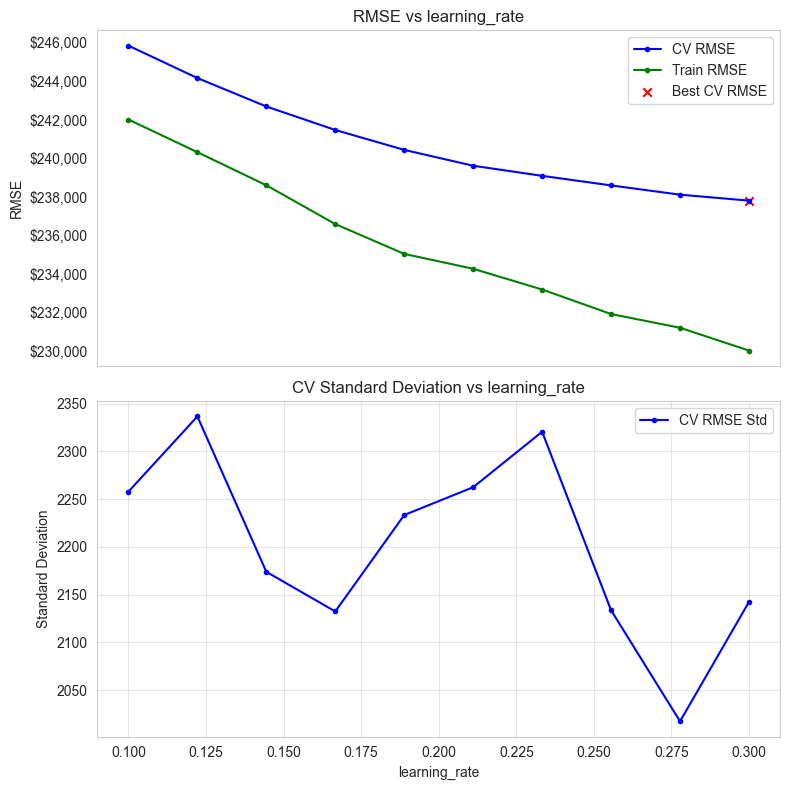

Execution Time: 00:06:50

Parameter learning_rate = 0.3; RMSE = $237,810

[]


Sweeping n_estimators: 100%|██████████| 29/29 [28:44<00:00, 59.45s/it] 


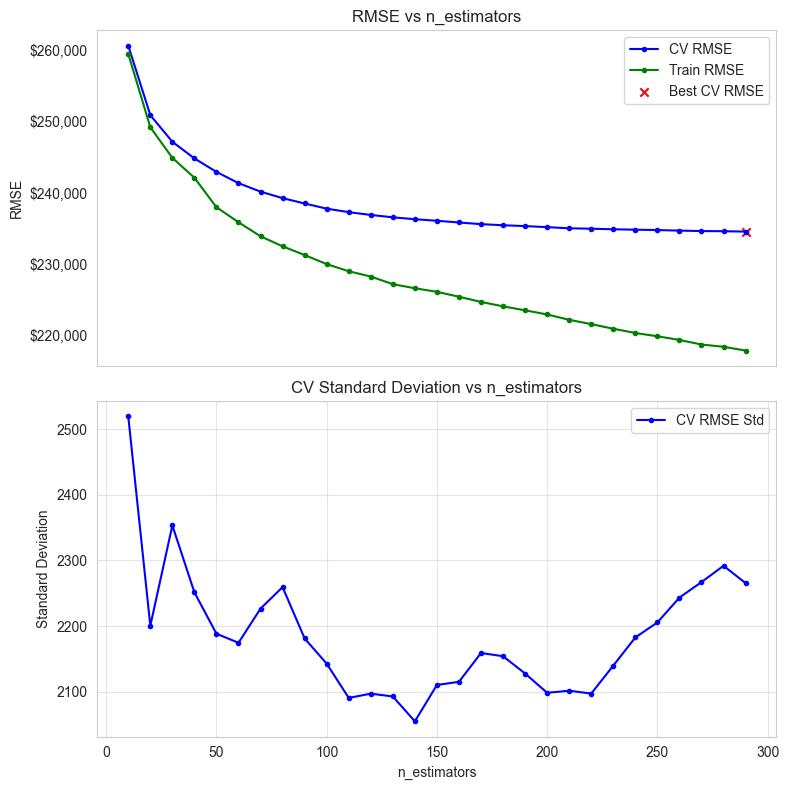

Execution Time: 00:28:44

Parameter n_estimators = 290; RMSE = $234,592

[]


Sweeping max_depth: 100%|██████████| 9/9 [40:57<00:00, 273.05s/it]


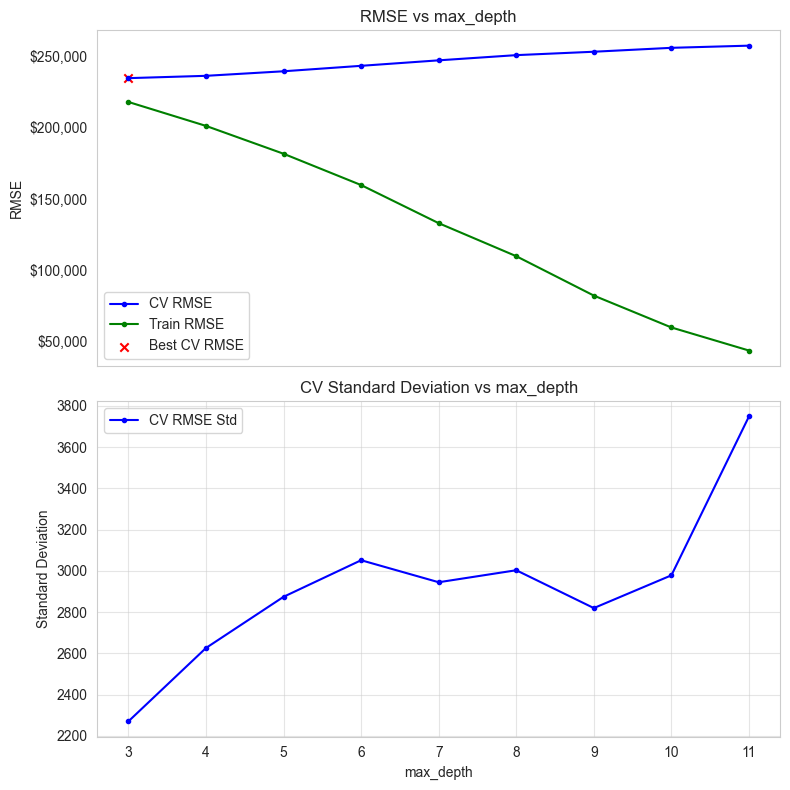

Execution Time: 00:40:57

Parameter max_depth = 3; RMSE = $234,613

[]


Sweeping max_features: 100%|██████████| 10/10 [11:13<00:00, 67.36s/it]


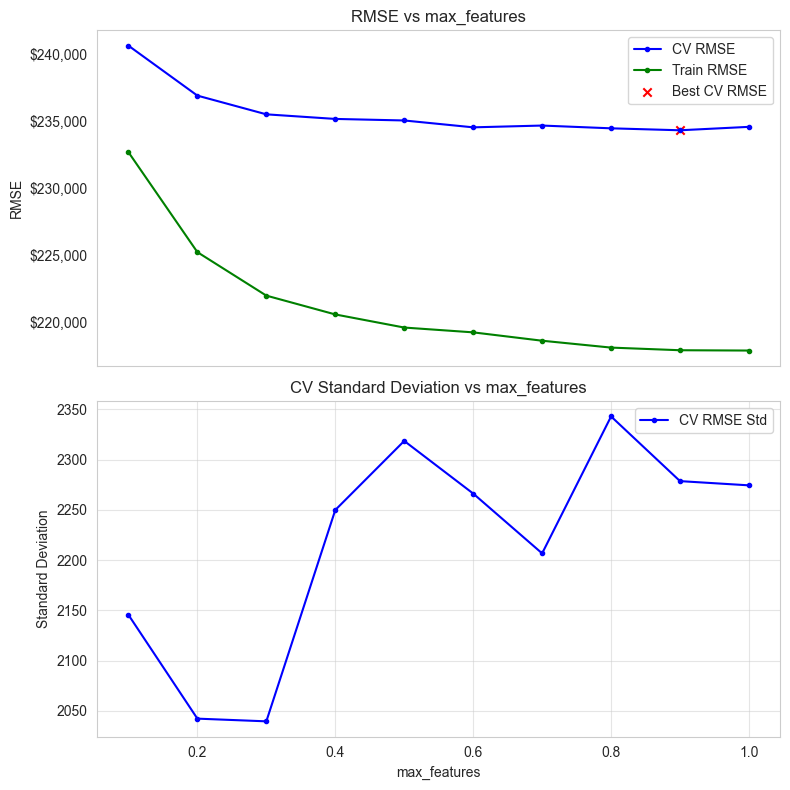

Execution Time: 00:11:13

Parameter max_features = 0.9; RMSE = $234,326

[]


,learning_rate,n_estimators,max_depth,max_features,random_state,RMSE_found
0,0.3,290,3,0.9,42,234326.360494


In [121]:
parameters_and_ranges_gb = [
    ('learning_rate', np.linspace(0.1, 0.3, 10)),
    ('n_estimators', range(10, 300, 10)),
    ('max_depth', range(3, 12, 1)),
    ('max_features', np.linspace(0.1, 1.0, 10))
]

for param, parameter_list in parameters_and_ranges_gb:
    Parameters_GB = sweep_parameter(GradientBoostingRegressor,
                                Parameters_GB,
                                param,
                                parameter_list,
                                x_train  = X_train_transformed_scaled_original_dropped,
                                y_train  = y_train
                                )

    print(f'\nParameter {param} = {Parameters_GB[param]}; RMSE = {dollar_format(Parameters_GB['RMSE_found'],2)}\n')
    print(Parameters_GB_list)

Parameters_GB_list.append(Parameters_GB)
pd.DataFrame(Parameters_GB_list)

- Reconsider **at least one decision from Milestone 2** (e.g., model evaluation, cross-validation strategy, or feature selection). Again, explain whether you would keep or revise your original decision, and why.

Since model tuning took the majority of time for Milestone 2, we made sacrifices by not tuning the models as well as possible. The biggest reconsideration for the Gradient boosting model was not running GridSearch or Randomized Search on parameter ranges found during parameter sweeps. When looking at the RMSE values from the parameter sweeps all values were under $240,000, while the combination of best parameters yielded an RMSE of over $245,000. We believe that utilizing a search method would drastically decrease the RMSE for the Gradient Boosting model.

In [141]:
GB_Params = Parameters_GB_list.copy()

In [143]:
# Grab the parameters for the best gradient boosting model
try:
    GB_Params = GB_Params[0].pop("RMSE_found")
except KeyError:
    gb_sweep_params = GB_Params[0]

# Evaluate the best gradient boosting model
gb_evaluation = evaluate_model({"Gradient Boosting Sweep": GradientBoostingRegressor(**gb_sweep_params)}, 
                               X_train_transformed_scaled_original_dropped, y_train)
gb_evaluation

Evaluating Gradient Boosting Sweep…


,Mean CV RMSE,STD CV RMSE,Train RMSE
Model,,,
Gradient Boosting Sweep,"$234,704","$2,251","$217,596"


## Grid Search

In [45]:
# Grid searh on the X_train and y_train data

# Record start time
start = time.time()

# Define the model
gb_model = GradientBoostingRegressor(random_state=random_state)

# Define the parameter grid
param_dist = {
    'n_estimators': range(10, 300, 10),
    'learning_rate': np.linspace(.1,.3,10),
    'max_features': [1.0],
    'max_depth': [3]                        
}

# Use GridSearchCV to find the best parameters
search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_dist,
    scoring='neg_root_mean_squared_error',  # MSE but negated for maximization by GridSearchCV
    cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=42),  # Number of folds for cross-validation -- Reduce this if efficiency is an issue
    n_jobs=-1,  # Use all available cores
    return_train_score=True
)

# Fit the GridSearchCV
search.fit(X_train_transformed_scaled_original_dropped, y_train)  

# Extract results into a DataFrame
results = pd.DataFrame(search.cv_results_)

# Select relevant columns for readability
results = results[[
    'param_n_estimators',
    'param_learning_rate',
    'param_max_features',
    'param_max_depth',
    'mean_test_score',
    'std_test_score',
    'mean_train_score',  # Include training score
    'std_train_score',   # Include standard deviation of training score
    'rank_test_score'
]]

# Convert negative MSE to positive
results['mean_test_score'] = -results['mean_test_score']
results['mean_train_score'] = -results['mean_train_score']

# Sort by rank (best scores first)
results = results.sort_values(by='rank_test_score')

# Rename columns for printing only
renamed_results = results.rename(
    columns={
        'param_n_estimators': 'n_estimators',
        'param_learning_rate': 'learning_rate',
        'param_max_features': 'max_features',
        'param_max_depth': 'max_depth',
        'mean_test_score': 'mean_cv_score',
        'std_test_score': 'std_cv_score',
        'mean_train_score': 'mean_train_score',
        'std_train_score': 'std_train_score'
    }
).drop(columns=['rank_test_score'])  # Drop the rank column for readability

# Print the results as a table
print("\nSearch Results (Top 5):\n")
print(renamed_results.head(5).to_string(index=False))  # Show the top 5 results with new headers

# Best parameters and test performance
gb_grid_best_params = search.best_params_
print(f"\nBest Parameters: {gb_grid_best_params}")
gb_grid_cv_acc = search.best_score_
print(f"Best CV RMSE: {gb_grid_cv_acc:.4f}")

# # Evaluate on the test set
# y_pred_gb = search.best_estimator_.predict(X_test)
# test_acc = root_mean_squared_error(y_test, y_pred_gb)

# print(f"Test RMSE:    {test_acc:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_hms(end-start))




Search Results (Top 5):

 n_estimators  learning_rate  max_features  max_depth  mean_cv_score  std_cv_score  mean_train_score  std_train_score
          290       0.255556           1.0          3  234307.286494   2368.860741     217546.494636       638.661189
          290       0.277778           1.0          3  234322.119930   2487.132526     216392.224367       648.777961
          280       0.255556           1.0          3  234340.521293   2391.179771     218041.725004       632.987777
          290       0.233333           1.0          3  234344.654936   2522.150062     218823.562282       645.009984
          280       0.277778           1.0          3  234379.989371   2492.653440     216896.351944       658.775765

Best Parameters: {'learning_rate': np.float64(0.25555555555555554), 'max_depth': 3, 'max_features': 1.0, 'n_estimators': 290}
Best CV RMSE: -234307.2865
Execution Time: 06:09:47


In [105]:
# Evaluate the best gradient boosting model
gb_grid_evaluation = evaluate_model({"Gradient Boosting Grid": gb_model.set_params(**gb_grid_best_params)}, 
                               X_train_transformed_scaled_original_dropped, y_train)
gb_grid_evaluation

Evaluating Gradient Boosting Grid…


,Mean CV RMSE,STD CV RMSE,Train RMSE
Model,,,
Gradient Boosting Grid,"$234,354","$2,187","$219,824"


In [144]:
# Merge all result tables
combined_results = pd.concat([baseline_results,gb_evaluation,gb_grid_evaluation])
combined_results = combined_results.sort_values(by="Mean CV RMSE")
combined_results

,Mean CV RMSE,STD CV RMSE,Train RMSE
Model,,,
Gradient Boosting Grid,"$234,354","$2,187","$219,824"
Gradient Boosting Sweep,"$234,704","$2,251","$217,596"
Random Forest,"$241,751","$2,342","$92,251"
Gradient Boosting,"$245,853","$2,259","$242,019"
Bagging,"$252,169","$2,215","$107,380"
Lasso,"$282,834","$2,837","$282,565"
Linear,"$282,835","$2,837","$282,565"
Ridge,"$282,835","$2,837","$282,565"
Decision Tree,"$332,569","$3,704","$24,149"


In [145]:
# cleaning the dataframe for visualization

# 1) Remove dollar‐signs and commas from every cell
df_clean = combined_results.replace({r'[\$,]': ''}, regex=True)

# 2) Convert all columns to numeric (float)
df_clean = df_clean.astype(float)

# 3) (Optional) round or format as you like
df_clean = df_clean.round(0).astype(int)

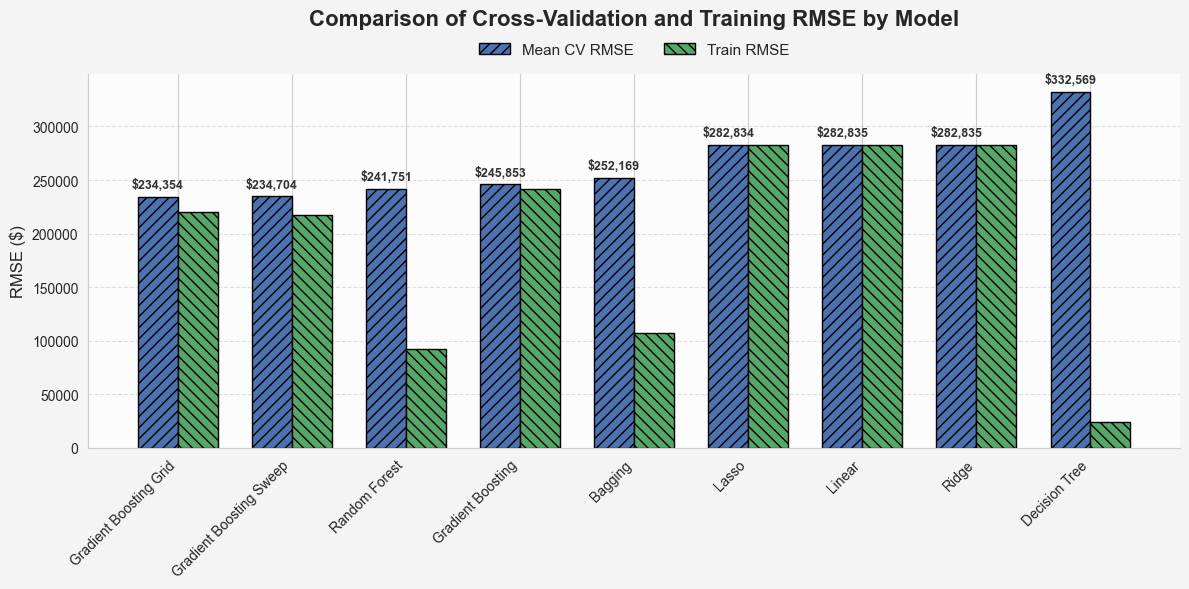

In [146]:
import numpy as np
import matplotlib.pyplot as plt

models = df_clean.index
x = np.arange(len(models))
width = 0.35

# Custom style
sns.set_style("whitegrid")
FIG_BG, AX_BG = "#F4F4F4", "#FCFCFC"

fig, ax = plt.subplots(figsize=(12, 6), facecolor=FIG_BG)
ax.set_facecolor(AX_BG)

colors    = ["#4C72B0", "#55A868"]
hatches   = ["///", "\\\\\\"]

# Plot bars
bars_cv    = ax.bar(
    x - width/2, df_clean["Mean CV RMSE"], width,
    label="Mean CV RMSE",
    color=colors[0], edgecolor="black", hatch=hatches[0]
)
bars_train = ax.bar(
    x + width/2, df_clean["Train RMSE"], width,
    label="Train RMSE",
    color=colors[1], edgecolor="black", hatch=hatches[1]
)

# Add value labels
for bar in bars_cv:
    h = bar.get_height()
    ax.annotate(
        f"${h:,.0f}",
        xy=(bar.get_x() + bar.get_width()/2, h),
        xytext=(0, 4),
        textcoords="offset points",
        ha="center", va="bottom",
        fontsize=9, fontweight="bold",
        color="#333"
    )

# Additional formatting
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right", fontsize=10)
ax.set_ylabel("RMSE ($)", fontsize=12)
ax.set_title(
    "Comparison of Cross-Validation and Training RMSE by Model",
    fontsize=16, fontweight="bold", pad=35
)

ax.legend(
    ncol=2, frameon=False,
    loc="upper center", bbox_to_anchor=(0.5, 1.12),
    fontsize=11
)

ax.grid(axis="y", linestyle="--", alpha=0.6)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.tight_layout() 
plt.show()


## Part B: Final Data Science Project Report Assignment [30 pts]

This final report is the culmination of your semester-long Data Science project, building upon the exploratory analyses and modeling milestones you've already completed. Your report should clearly communicate your findings, analysis approach, and conclusions to a technical audience. The following structure and guidelines, informed by best practices, will help you prepare a professional and comprehensive document.

### Required Sections

Your report must include the following sections:


#### 1. Executive Summary (Abstract) [2 pts]
- Brief overview of the entire project (150–200 words)
- Clearly state the objective, approach, and key findings

#### 2. Introduction [2 pts]
- Clearly introduce the topic and context of your project
- Describe the problem you are addressing (the problem statement)
- Clearly state the objectives and goals of your analysis

Note: You may imaginatively consider this project as taking place in a real estate company with a small data science group in-house, and write your introduction from this point of view (don't worry about verisimilitude to an actual company!).  

#### 3. Data Description [2 pts]
- Describe the source of your dataset (described in Milestone 1)
- Clearly state the characteristics of your data (size, types of features, missing values, target, etc.)

#### 4. Methodology (What you did, and why)  [12 pts]

**Focus this section entirely on the steps you took and your reasoning behind them. Emphasize the process and decision-making, not the results themselves**

- Describe your analytical framework 
  - Use of validation curves to see the effect of various hyperparameter choices, and
  - Choice of RMSE as primary error metric
- Clearly outline your data cleaning and preprocessing steps
  - Describe what issues you encountered in the raw data and how you addressed them.
  - Mention any key decisions (e.g., removing samples with too many missing values).
  - What worked and what didn't work?
- Describe your feature engineering approach
  - Explain any transformations, combinations, or derived features.
  - Discuss why certain features were chosen or created, even if they were later discarded.
  - What worked and what didn't work?
- Detail your model selection process 
  - Outline the models you experimented with and why.
  - Discuss how you evaluated generalization (e.g., cross-validation, shape and relationships of plots).
  - Mention how you tuned hyperparameters or selected the final model.



#### 5. Results and Evaluation (What you found, and how well it worked) [10 pts]

**Focus purely on outcomes, with metrics, visuals, and insights. This is where you present evidence to support your conclusions.**

- Provide a clear and detailed narrative of your analysis and reasoning using the analytical approach described in (4). 
- Discuss model performance metrics and results (RMSE, R2, etc.)
- **Include relevant visualizations (graphs, charts, tables) with appropriate labels and captions**
- Error analysis
  - Highlight specific patterns of error, outliers, or questionable features.
  - Note anything surprising or worth improving in future iterations.


#### 6. Conclusion [2 pts]
- Clearly state your main findings and how they address your original objectives
- Highlight the business or practical implications of your findings 
- Discuss the limitations and constraints of your analysis clearly and transparently
- Suggest potential improvements or future directions